# Predicting Mortality of ICU Patients

A local hospital system wants to explore a new strategy for reducing Intensive Care Unit (ICU) mortality:

At the beginning of the shift, a team of specialist doctors will spend some extra time reviewing patient files, and deciding what intervention is needed for each patient.

If the doctor identifies the correct intervention, a patient's death may be prevented. However, the probability of missing the correct intervention depends on the time spent reviewing the file. Given that there is a finite budget for doctors' time, it is critically important to have an effective policy for deciding which files to review.

You have been hired to explore the likely impact of different policies for selecting patient files, including a policy that uses machine learning to recommend patient files for extra review.

In the attached workspace, you will read in some data from ICU patients, use it to train a classifier, and then use simulation to evaluate different policies for patient file review.

In [1]:
import pandas as pd
import numpy as np
import glob, os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve
import matplotlib.pyplot as plt

The data in this exercise comes from [Predicting Mortality of ICU Patients: The PhysioNet/Computing in Cardiology Challenge 2012](https://physionet.org/content/challenge-2012/1.0.0/).

The data is described as follows:

> All patients were adults who were admitted for a wide variety of reasons to cardiac, medical, surgical, and trauma ICUs. ICU stays of less than 48 hours have been excluded. Patients with DNR (do not resuscitate) or CMO (comfort measures only) directives were not excluded.
>
> Up to 42 variables were recorded at least once during the first 48 hours after admission to the ICU. Not all variables are available in all cases, however. Six of these variables are general descriptors (collected on admission), and the remainder are time series, for which multiple observations may be available.
>
> Each observation has an associated time-stamp indicating the elapsed time of the observation since ICU admission in each case, in hours and minutes. Thus, for example, a time stamp of 35:19 means that the associated observation was made 35 hours and 19 minutes after the patient was admitted to the ICU.



The data is in an archive called `set-a.zip`, which we will extract (it may take a few minutes):

In [2]:
# !unzip -q -o set-a.zip
!tar -xf set-a.zip

Now we have a folder called `set-a`, with one file per patient. We will read in all the patient files into a `pandas` DataFrame with the following columns:

In [3]:
col_names = ["Age", "Gender", "Height", "Weight", "Urine",
         "HR", "Temp", "NIDiasABP", "SysABP", "DiasABP", "pH",
         "PaCO2", "PaO2", "Platelets", "MAP", "K", "Na", "FiO2", "GCS", "RecordID"]

For the time series data, we will read in the mean value per patient.

In [4]:
def read_patient_data(dat, col_names):
    # Missing values are encoded in the data as -1, so replace -1 values with true NaN
    dat[dat == -1.0] = float('NaN')

    # then read each mean of each feature into a dictionary
    dat_dict = {}
    for c in col_names:
        dat_dict[c] = [dat["Value"][dat["Parameter"]==c].mean(axis = 0)]
    return dat_dict

In [5]:
# create an empty DataFrame to hold the data
df  = pd.DataFrame(columns = col_names)
filenames = sorted(glob.glob("set-a/*.txt"))

# read in each patient file and add it to the end of df
for filename in filenames:
    patient_dat = pd.DataFrame.from_dict(
        read_patient_data(pd.read_csv(filename, delimiter=','),
                          col_names)
        )
    df = pd.concat([df, patient_dat])


C:\Users\cj\AppData\Local\Temp\ipykernel_18244\3351938028.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, patient_dat])


Now, we read in the outcomes of the patients whose physiological recordings were loaded above -

In [6]:
outcome_dat = pd.read_csv("Outcomes-a.txt")
outcome_dat[outcome_dat == -1] = float('NaN') # set all -1 to NaNs
df = df.merge(outcome_dat, left_on='RecordID', right_on='RecordID')

Look at a few samples of `df` to make sure it is loaded correctly - 

In [7]:
df.head()

,Age,Gender,Height,Weight,Urine,HR,Temp,NIDiasABP,SysABP,DiasABP,...,K,Na,FiO2,GCS,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,54.0,0.0,NaN,NaN,171.052632,70.810811,37.357143,50.147059,NaN,NaN,...,4.20,136.500000,NaN,14.923077,132539.0,6.0,1.0,5.0,NaN,0
1,76.0,1.0,175.3,80.670588,151.560976,80.794118,36.939130,56.714286,113.411765,58.897059,...,3.90,137.000000,0.56,13.333333,132540.0,16.0,8.0,8.0,NaN,0
2,44.0,0.0,NaN,56.700000,124.951220,83.759259,37.800000,79.000000,125.687500,67.125000,...,4.26,138.333333,0.50,5.923077,132541.0,21.0,11.0,19.0,NaN,0
3,68.0,1.0,180.3,84.600000,545.833333,70.983333,36.223077,65.051724,NaN,NaN,...,4.00,139.333333,NaN,14.944444,132543.0,7.0,1.0,9.0,575.0,0
4,88.0,0.0,NaN,NaN,62.131579,74.958333,36.880000,45.720930,NaN,NaN,...,4.32,139.500000,NaN,15.000000,132545.0,17.0,2.0,4.0,918.0,0


### Prepare training, validation, and test sets

Next, we will divide the data into training, validation, and test sets.

* The training data will be used to fit a classifier model to predict patients at risk of mortality
* The validation data will be used to explore different policies
* The test data will be used at the end, to evaluate the effect of the selected policy

Use two calls to `train_test_split` to divide the data as follows:

* First, split `df` into a training set and a test set.
* Then, further divide the training set from the first split into a training set and validation set.

Also:

* In both calls to `train_test_split`, shuffle the data, and use `random_state=0` so your result will match the auto-grader's result. 
* Select all of the features in `col_names` *except* `RecordID` to create `Xtr`, `Xvl`, `Xts` from `df`.
* Select only the `In-hospital_death` column to create `ytr`, `yvl`, `yts` from `df`. 
* Use `.values` so that `ytr`, `yvl`, `yts` will be a `numpy` array. Leave `Xtr`, `Xvl`, `Xts` as data frames.
* You should have 800 samples in the test set and 800 samples in the validation set.


In [8]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
X = df[col_names[:-1]]
y = df['In-hospital_death'].values 
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=800, shuffle=True, random_state=0)
Xtr, Xvl, ytr, yvl = train_test_split(Xtr, ytr, test_size=800, shuffle=True, random_state=0)

Before we proceed, we will also fill in missing values in `Xtr`, `Xvl`, `Xts` as follows:

* We will compute the [`median`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.median.html) for each column in `Xtr`, and save the results in `col_meds`. 
* Then, we will use the [`fillna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html) function in `pandas`, and pass `col_meds` as the `value` to use to fill holes.

Note that we use the median values *computed on the training set* to fill in missing values for all three sets - training, validation, and test.

In [9]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
col_meds = Xtr.median()
Xtr = Xtr.fillna(col_meds)
Xvl = Xvl.fillna(col_meds)
Xts = Xts.fillna(col_meds)

### Fit a Logistic Regression model

We will explore a policy that uses a logistic regression model to prioritize patient files for review.

Using the training data, fit a `LogisticRegression` to predict in-hospital death.

* Use `random_state = 0` so your result will match the auto-grader's.
* Specify that no regularization penalty should be used.
* Leave other settings at their default value.


In [10]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
clf = LogisticRegression(random_state = 0, penalty=None)
clf.fit(Xtr, ytr)

c:\Users\cj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(penalty=None, random_state=0)

Get the accuracy score of your model on the validation set, and save the result in `acc_lr`:

In [11]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
y_pred_lr = clf.predict(Xvl)
acc_lr = accuracy_score(yvl, y_pred_lr)

Also compute the validation accuracy of a model that does 'prediction by mode' - that predicts the same class label (whatever the most frequent class label is in the training set) for all data. Save the result in `acc_base`:

In [12]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
most_frequent_label = np.bincount(ytr).argmax()
y_pred_base = np.full_like(yvl, most_frequent_label)
acc_base = accuracy_score(yvl, y_pred_base)


Does our model have better accuracy than "prediction by mode"?

Do you think accuracy is an appropriate metric for evaluating this model? Why or why not?

### Plot the ROC curve

Using the [`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) function in `sklearn`, get the FPR and TPR for a range of thresholds, for the validation set.

You will pass to `roc_curve`:
* `yvl` - the true values for the validation set
* the estimated probability of mortality (probability of belonging to class 1), for the samples in the validation set

You can get the probabilities from the `predict_proba` method of your classifier. This will return an array with `n_samples` rows and `n_classes` columns. Each column $j$ corresponds to the probability of belonging to class $j$.

The `roc_curve` function will return three arrays - an array of FPR values, an array of TPR values, and the array of classifiers thresholds corresponding to those values.

In [13]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
y_proba = clf.predict_proba(Xvl)[:, 1]
fpr, tpr, thresholds = roc_curve(yvl, y_proba)

Then, plot the ROC curve, with FPR on the horizontal axis and TPR on the vertical axis.

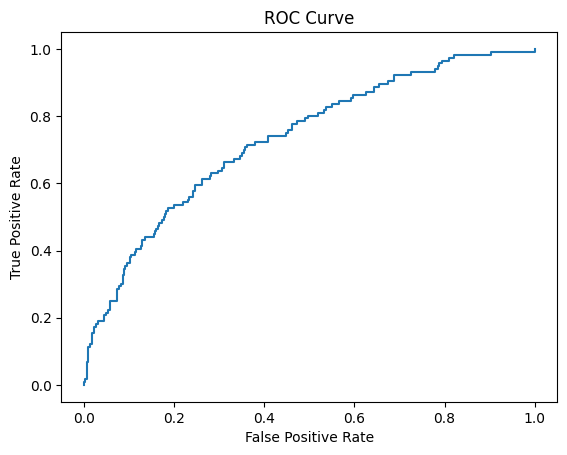

In [14]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

What threshold would we use if we wanted to identify 90% of the patients at risk of mortality? What would be the FPR in this case? Why might it be appropriate for this application to choose a threshold that identifies most patients at risk of mortality, even if it comes with many false positives?

### Modeling doctors' decision making

Now that we have a trained model, we will explore its use in a hospital context.

Suppose we have a new strategy that is intended to reduce ICU mortality. It will work as follows:

* At the beginning of the shift, a team of specialist doctors will spend some extra time reviewing patient files, and deciding what intervention is needed for each patient.
* If the doctor identifies the correct intervention, the patient will not die.
* However, the probability of *missing* the correct intervention depends on the time spent reviewing the file.

If the doctor spends $t$ minutes reviewing a file, the probability of *missing* the correct treatment is

$$P(\textrm{fail}) = \exp(-t^2/100).$$



It's not possible to precisely measure the effect of a system like this using the observational data that we have available to us. To evaluate the effect of the proposed system, we would have to run a controlled experiment.

However, to the extent possible, we should try to understand the policy impact first - we will do so by simulation.

#### Policy 0: No extra review

First, as a baseline, let's compute the number of deaths in the validation set. Save the result in `mort_0`:

In [15]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
mort_0 = np.sum(yvl)

#### Policy 1: Review all files

Now suppose the specialist team will spend

$$\frac{N}{25} \times 60$$

minutes total on extra review, where $N$ is the number of files in the validation set, and they will spend an equal amount of time on each of the $N$ files in the validation set.

Compute:

* `t_1` - the time (in minutes) spent on each file
* `p_1` - the probability of failing to identify the correct intervention, given this `t`

and then use them to find the expected number of deaths in the validation set, with this policy. Save this value in `mort_1`.

In [16]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
# Number of validation samples
N = len(yvl)

# Step 1: Compute time spent per file
t_1 = (N / 25) * 60  / N  # Minutes per file

# Step 2: Compute probability of missing correct intervention
p_1 = np.exp(-t_1**2 / 100)

# Step 3: Compute expected mortality under Policy 1
mort_1 = np.sum(yvl * p_1)

#### Policy 2: Review high-risk files with 0.5 threshold

Now, suppose that the doctor only reviews the files of patients for whom the model outputs a probability of mortality greater than 50%. They will spend the same total amount of time as before, 


$$\frac{N}{25} \times 60$$

minutes total on extra review, where $N$ is the number of files in the validation set.  But now they will review fewer files.

This would give the doctor more time to look through each file, but the doctor would never be able to intervene in the cases of patients that the model considers very low risk.


Compute:

* `t_2` - the time (in minutes) spent on each file
* `p_2` - the probability of failing to identify the correct intervention, given this `t`

and then use them to find the expected number of deaths in the validation set, with this policy. Save this value in `mort_2`.

In [17]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
# Step 1: Predict probabilities of mortality for the validation set
y_proba_vl = clf.predict_proba(Xvl)[:, 1]

# Identify high-risk and low-risk patients
high_risk_indices = [i for i in range(len(yvl)) if y_proba_vl[i] > 0.5]
low_risk_indices = [i for i in range(len(yvl)) if y_proba_vl[i] <= 0.5]

# Number of high-risk files
N_high_risk = len(high_risk_indices)

# Step 2: Calculate t_2
N = len(yvl)
T = (N / 25) * 60
t_2 = T / N_high_risk

# Step 3: Calculate p_2
p_2 = np.exp(-t_2**2 / 100)

# Step 4: Estimate expected deaths
mort_2 = 0
for i in high_risk_indices:
    if yvl[i] == 1:  # Patient would have died without review
        mort_2 += p_2  # Adjusted probability of death
    else:
        mort_2 += 0  # No death for survivors

for i in low_risk_indices:
    mort_2 += yvl[i]  # No review, so deaths remain unchanged

#### Policy 3: Review high-risk files with optimal threshold

Finally, we will find the classifier threshold that minimizes the expected mortality in the validation set.

For all thresholds in `np.arange(0, 1, 0.01)`, compute the expected mortality, given the doctor only reviews the files of patients for whom the model outputs a probability of mortality greater than that threshold. They will spend the same total amount of time as before, 


$$\frac{N}{25} \times 60$$

minutes total on extra review, where $N$ is the number of files in the validation set. 

Save the results in `mort_thr`.


In [18]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
# thr_list = np.arange(0, 1, 0.01)
# mort_thr = np.zeros(len(thr_list))
# # fill in mort_thr...


# Step 1: Predict probabilities of mortality for the validation set
y_proba_vl = clf.predict_proba(Xvl)[:, 1]  # Predicted probabilities for validation set

# Total number of files in the validation set
N = len(yvl)

# Total time spent on extra review (same as in Policy 1 and Policy 2)
T = (N / 25) * 60

# Step 2: Initialize arrays to store results
thr_list = np.arange(0, 1, 0.01)  # List of thresholds
mort_thr = np.zeros(len(thr_list))  # Array to store expected mortality for each threshold

# Step 3: Iterate over thresholds
for i, t in enumerate(thr_list):
    # Identify high-risk patients (probability > threshold)
    high_risk_indices = np.where(y_proba_vl > t)[0]
    low_risk_indices = np.where(y_proba_vl <= t)[0]
    
    # Number of high-risk files
    N_high_risk = len(high_risk_indices)
    
    # Skip if there are no high-risk patients (to avoid division by zero)
    if N_high_risk == 0:
        mort_thr[i] = np.sum(yvl[low_risk_indices])  # No review, so deaths remain unchanged
        continue
    
    # Calculate time spent on each high-risk file
    t_2_3 = T / N_high_risk
    
    # Calculate probability of failing to identify the correct intervention
    p_2 = np.exp(-t_2_3**2 / 100)
    
    # Estimate expected deaths
    mort_high_risk = np.sum(yvl[high_risk_indices] * p_2)  # Adjusted probability for high-risk patients
    mort_low_risk = np.sum(yvl[low_risk_indices])  # No review for low-risk patients
    
    # Total expected deaths
    mort_thr[i] = mort_high_risk + mort_low_risk

Plot the expected mortality against the threshold:

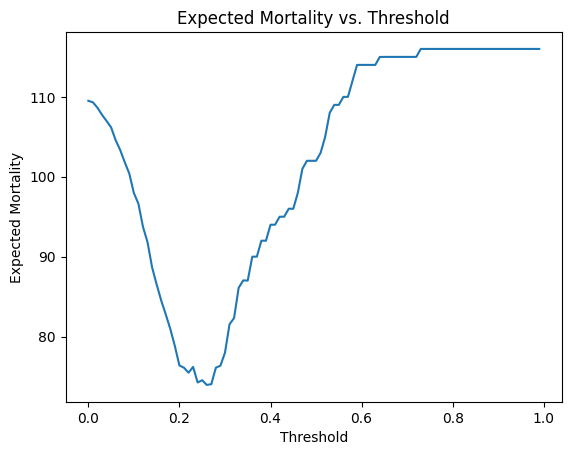

In [19]:
plt.plot(thr_list, mort_thr);
plt.xlabel('Threshold');
plt.ylabel('Expected Mortality');
plt.title('Expected Mortality vs. Threshold');

Find 

* `thr_opt`, the threshold that minimizes mortality on the validation set, and 
* `mort_3`, the expected mortality on the validation set with this threshold.

In [20]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
thr_opt = thr_list[np.argmin(mort_thr)]
# mort_3 = np.min(mort_thr)
mort_3 = np.min(mort_thr[mort_thr > 0]) if np.any(mort_thr > 0) else np.min(mort_thr)

### Evaluate on the test set

Finally, compute the mortality (number of deaths) in the test set:

In [21]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
mort_ts = np.sum(yts)

and compute the number of lives that would be saved *on the test set*:

* by Policy 0: no review
* by Policy 1: review all
* by Policy 2: review using 50% threshold
* by Policy 3: review using `thr_opt` found in the previous part

In [22]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
# saved_0 = 0
# saved_1 = ...
# saved_2 = ...
# saved_3 = ...
# First, calculate the total number of deaths in the test set
mort_ts = np.sum(yts)

# Policy 0: no review, so no lives are saved
saved_0 = 0

# Policy 1: review all
# Calculate the total time available for review
N = len(yts)
total_time = (N / 25) * 60
t_ts_1 = total_time / N
p_ts_1 = np.exp(-(t_ts_1 ** 2) / 100)
at_risk_patients = np.sum(yts)
mort_ts_1 = at_risk_patients * p_ts_1
saved_1 = mort_ts - mort_ts_1

# Policy 2: review using 50% threshold
y_proba_ts = clf.predict_proba(Xts)[:, 1]
high_risk_patients = y_proba_ts > 0.5
num_high_risk = np.sum(high_risk_patients)
t_ts_2 = total_time / num_high_risk if num_high_risk > 0 else 0
p_ts_2 = np.exp(-(t_ts_2 ** 2) / 100)
at_risk_high_risk = np.sum(yts[high_risk_patients])
at_risk_low_risk = np.sum(yts[~high_risk_patients])
mort_ts_2 = at_risk_high_risk * p_ts_2 + at_risk_low_risk
saved_2 = mort_ts - mort_ts_2

# Policy 3: review using thr_opt
high_risk_patients = y_proba_ts > thr_opt
num_high_risk = np.sum(high_risk_patients)
t_ts_3 = total_time / num_high_risk if num_high_risk > 0 else 0
p_ts_3 = np.exp(-(t_ts_3 ** 2) / 100)
at_risk_high_risk = np.sum(yts[high_risk_patients])
at_risk_low_risk = np.sum(yts[~high_risk_patients])
mort_ts_3 = at_risk_high_risk * p_ts_3 + at_risk_low_risk
saved_3 = mort_ts - mort_ts_3

Plot the results: make a bar plot showing the values of `saved_0`, `saved_1`, `saved_2`, and `saved_3`, and showing the total mortality as a horizontal line.

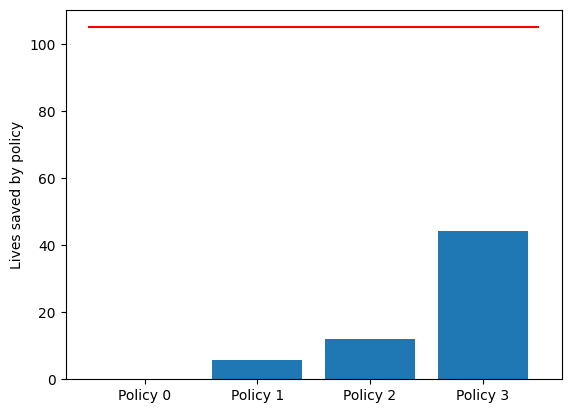

In [23]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

plt.bar(["Policy 0", "Policy 1", "Policy 2", "Policy 3"], [saved_0, saved_1, saved_2, saved_3]);
plt.hlines(mort_ts, xmin=-0.5, xmax=3.5, colors='r');
plt.ylabel("Lives saved by policy");
